In [60]:
import os
import re
import random
import time
import math
import datetime
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image as pimage
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm


In [45]:
def parse_image(img_path: str) -> dict:
    '''
    Loads the image and its mask, returns a dictionary

    Original      Returns
    0: obstacle   0: obstacle
    1: water      1: water
    2: sky        2: sky
    4: unknown    3: unknown

    Args
    ----------
    img_path : str
        Image filename pattern (glob)
        (Mask location is found using regex)

    Returns
    ----------
    dict {'image': tensor (384 x 512 x 3), 'mask': tensor (384 x 512 x 1)}
        Dictionary mapping an image and its annotation.
    '''
    
    image = pimage.open(img_path).convert("RGB")
    transform = transforms.ToTensor()
    image = transform(image)
    
    # For one Image path:
    # .../data/images/train/01_001.png
    # Its corresponding annotation path is:
    # .../data/annotations/train/01_001_label.png
    mask_path = re.sub(r"images", "masks", img_path)
    mask_path = re.sub(r".jpg", "m.png", mask_path)

    mask = pimage.open(mask_path)
    # Convert to pytorch tensor
    mask = torch.from_numpy(np.array(mask)).unsqueeze(0)
    mask = torch.where(mask == 4, torch.tensor(3, dtype=torch.float32), mask)
    # Mask中都是 0 1 2 3
    
    return {'image': image, 'mask': mask}

In [46]:
def load_image_train(datapoint: dict) -> tuple:
    '''
    Apply some transformations to an input dictionary
    containing an image and its annotation.

    Note: should be applying to training set only

    Args
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    ----------
    tuple
        A modified image and its annotation.
    '''

    input_image = datapoint['image']
    input_mask = datapoint['mask']
    height, width = 384, 512

    # Flip
    if random.random() > 0.5:
        input_image = TF.hflip(input_image)
        input_mask = TF.hflip(input_mask)

    # Hue, Saturation, Contrast, Brightness
    if random.random() > 0.2:
        input_image = TF.adjust_hue(input_image, random.uniform(-0.2, 0.2))
        input_image = TF.adjust_saturation(input_image, random.uniform(0.8, 1.2))
        input_image = TF.adjust_contrast(input_image, random.uniform(0.6, 1.4))
        input_image = TF.adjust_brightness(input_image, random.uniform(0.8, 1.2))

    # Rotation
    if random.random() > 0.2:
        angle = random.uniform(-22.5, 22.5)  # -pi/8 to pi/8 in degrees
        input_image = TF.rotate(input_image, angle, resample=pimage.BILINEAR)
        input_mask = TF.rotate(input_mask, angle, resample=pimage.NEAREST, fill=3)

    # Scaling
    if random.random() > 0.2:
        crop_width = random.randint(math.floor(0.7 * width), math.floor(0.9 * width))
        crop_height = random.randint(math.floor(0.7 * height), math.floor(0.9 * height))

        offset_x = random.randint(0, width - crop_width)
        offset_y = random.randint(0, height - crop_height)

        input_image = TF.crop(input_image, offset_y, offset_x, crop_height, crop_width)
        input_mask = TF.crop(input_mask, offset_y, offset_x, crop_height, crop_width)

    # Resize
    input_image = TF.resize(input_image, (IMG_SIZE, IMG_SIZE), interpolation=pimage.BILINEAR)
    input_mask = TF.resize(input_mask, (IMG_SIZE, IMG_SIZE), interpolation=pimage.NEAREST)

    # Normalize & clip
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = torch.clamp(input_image, 0., 1.)

    return input_image, input_mask


In [66]:
IMG_SIZE = 224
# Batch size is set to 32 in order to see if inference at real time is possible
BATCH_SIZE = 32
N_CLASSES = 4         # 0: obstacle, 1: water, 2: sky
TRAIN_VAL_RATIO = 0.90 # Within the MasTr dataset


# For reproducible result 
SEED = 321
# tf.random.set_seed(SEED)

In [48]:
data_dir = os.path.join(os.getcwd(), 'data/')
images_path = os.path.join(os.getcwd(), 'data/images/')
labels_path = os.path.join(os.getcwd(), 'data/masks/')

test_data_dir = os.path.join(os.getcwd(), 'data/')
test_images_path = os.path.join(os.getcwd(), 'test_data/images/')
test_labels_path = os.path.join(os.getcwd(), 'test_data/masks/')

eval_data_dir = os.path.join(os.getcwd(), 'eval_data/')
eval_images_path = os.path.join(os.getcwd(), 'eval_data/images/')
eval_labels_path = os.path.join(os.getcwd(), 'eval_data/masks/')

total_image_count = len(os.listdir(images_path))


print('total number of images:      {}'.format(total_image_count))

total number of images:      1325


In [49]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize the image to 224x224
])

In [50]:
# 获取所有图像文件的列表
all_images = glob.glob(images_path + '*.jpg')
random.shuffle(all_images)

# 获取测试集和验证集的图像文件列表
test_sequence_folders = ['seq27', 'seq28']
eval_images = glob.glob(eval_images_path + 'seq*' + '/*.jpg')
test_images = [glob.glob(eval_images_path + seq + '/*.jpg') for seq in test_sequence_folders]
test_images = [item for sublist in test_images for item in sublist]  # Flatten the list

# 按照比例划分训练集和验证集
train_images, val_images = train_test_split(all_images, train_size=TRAIN_VAL_RATIO, random_state=SEED)

# 获取各数据集的大小
TRAINSET_SIZE = len(train_images)
VALSET_SIZE = len(val_images)
TEST_SIZE = len(test_images)
EVAL_SIZE = len(eval_images)

print(f'Train: {TRAINSET_SIZE}, Val: {VALSET_SIZE}, Test: {TEST_SIZE}, Eval: {EVAL_SIZE}')

# 创建PyTorch数据集类
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        sample = parse_image(img_path)  # 使用之前定义的parse_image函数
        image, mask = sample['image'], sample['mask']
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        
        return image, mask

# 创建数据集实例
train_dataset = CustomDataset(train_images, transform=train_transform)
val_dataset = CustomDataset(val_images, transform=train_transform)
# parse_image已经对图像进行了totensor，不用再进一步/255了
# val_dataset = CustomDataset(val_images, transform=normalize)
test_dataset = CustomDataset(test_images, transform=train_transform)
eval_dataset = CustomDataset(eval_images, transform=train_transform)

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)


Train: 1192, Val: 133, Test: 0, Eval: 0


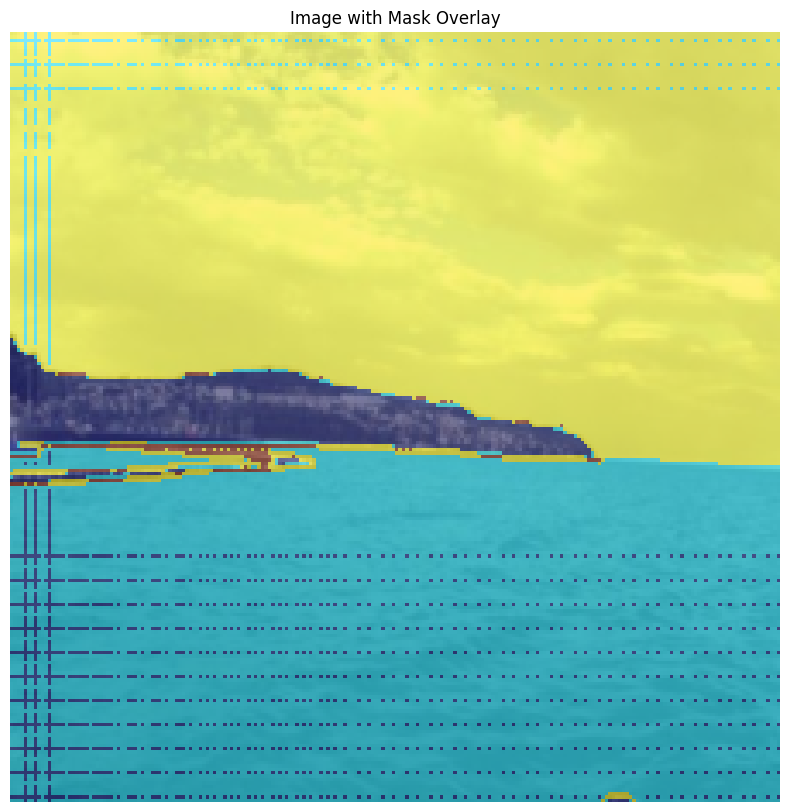

In [51]:
# 显示一个示例
image, mask = val_dataset[0]

# 将张量转换为图像
transform_to_pil = transforms.ToPILImage()

image_pil = transform_to_pil(image)
mask_pil = transform_to_pil(mask/255)

plt.figure(figsize=(10, 10))

plt.imshow(image_pil)
plt.imshow(mask_pil, cmap='jet', alpha=0.5)
plt.title("Image with Mask Overlay")
plt.axis('off')
plt.show()


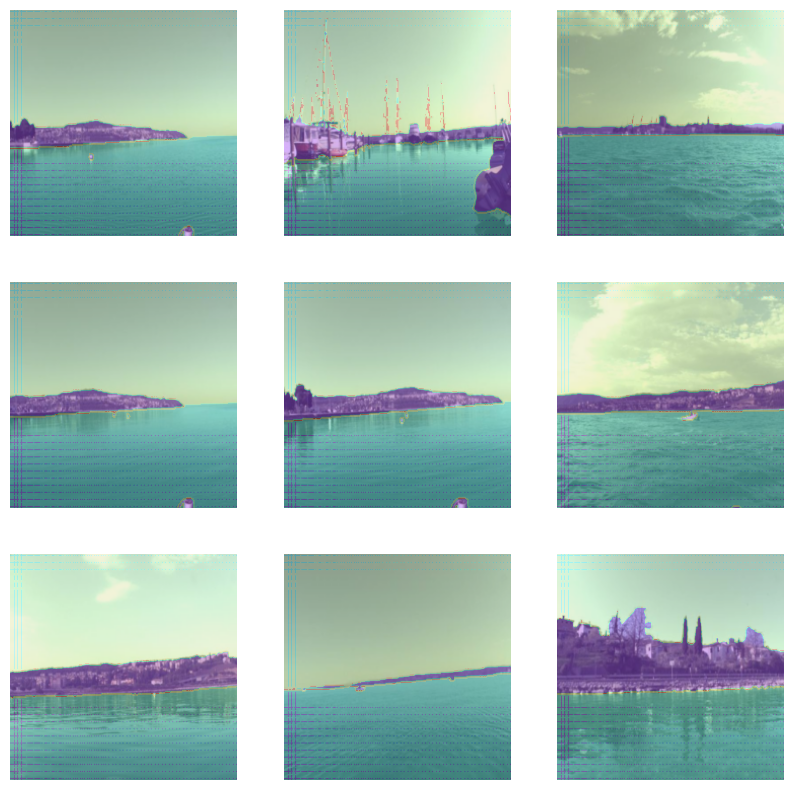

In [9]:
# 显示一个批次的图像和掩码
def show_batch_image_mask(image_batch, mask_batch):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # 显示一个示例
        image = image_batch[i]
        mask = mask_batch[i]

        # 将张量转换为图像
        transform_to_pil = transforms.ToPILImage()

        image_pil = transform_to_pil(image)
        mask_pil = transform_to_pil(mask/255)

        plt.imshow(image_pil)
        plt.imshow(mask_pil, cmap='rainbow', alpha=0.3)

        plt.axis("off")
    plt.show()

# 获取并显示一个批次的图像和掩码
for image_batch, mask_batch in val_loader:
    show_batch_image_mask(image_batch, mask_batch)
    break

In [10]:
# # 定义一个模块，用于提取中间层特征
# class MobileNetV2Features(nn.Module):
#     def __init__(self):
#         super(MobileNetV2Features, self).__init__()
#         self.mobilenet_v2 = models.mobilenet_v2(pretrained=True).features
        
#         # 指定所需的层
#         self.layer_names = [
#             '0',  # block_1_expand_relu: 64 x 64 x 96
#             '3',  # block_3_expand_relu: 32 x 32 x 144
#             '6',  # block_6_expand_relu: 16 x 16 x 192
#             '13', # block_13_expand_relu: 8  x 8  x 576
#             '16', # block_16_project:    4  x 4  x 320
#         ]
        
#         # 获得所需层的索引
#         self.layers = [int(name) for name in self.layer_names]

#     def forward(self, x):
#         outputs = []
#         for i, layer in enumerate(self.mobilenet_v2):
#             x = layer(x)
#             if i in self.layers:
#                 outputs.append(x)
#         return outputs

# # 创建特征提取模型实例
# encoder = MobileNetV2Features()
# print(encoder)

# # 设置模型为评估模式
# encoder.eval()

# # 示例输入
# input_tensor = torch.randn(1, 3, 224, 224)

# # 获取特征
# features = encoder(input_tensor)

# # 打印每个特征的形状
# for i, feature in enumerate(features):
#     print(f"Shape of feature from layer {encoder.layer_names[i]}: {feature.shape}")

In [11]:
# def deconv_block(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, dropout_rate=0.5):
#     '''
#     ConvTranspose2d => BatchNorm2d => Dropout => ReLU
#     '''
#     layers = []
#     layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False, output_padding=output_padding))
#     layers.append(nn.BatchNorm2d(out_channels))
#     if dropout_rate > 0:
#         layers.append(nn.Dropout(dropout_rate))
#     layers.append(nn.ReLU(inplace=True))
#     return nn.Sequential(*layers)

In [12]:
# # 定义 up_stack
# up_stack = nn.ModuleList([
#     deconv_block(160, 512, dropout_rate=0.5),  # 4x4 -> 8x8
#     deconv_block(608, 256, dropout_rate=0.4),  # 8x8 -> 16x16
#     deconv_block(288, 128, dropout_rate=0.3),  # 16x16 -> 32x32
#     deconv_block(152, 64, dropout_rate=0.2),   # 32x32 -> 64x64
# ])

# # 示例用法
# class Decoder(nn.Module):
#     def __init__(self, up_stack):
#         super(Decoder, self).__init__()
#         self.up_stack = up_stack

#     def forward(self, x, skips):
#         # for layer in self.up_stack:
#         #     x = layer(x)

#         for up, skip in zip(self.up_stack, skips):
#             x = up(x)
#             # print(x.shape, skip.shape)
#             x = torch.cat([x, skip], dim=1)
#         return x

# # 创建解码器实例
# decoder = Decoder(up_stack)

# # 打印模型结构
# print(decoder)


In [13]:
# # 定义完整的 UNet 模型
# class unet_model(nn.Module):
#     def __init__(self, encoder, decoder, n_classes):
#         super(unet_model, self).__init__()
#         self.encoder = encoder
#         self.decoder = decoder
#         self.final = nn.ConvTranspose2d(96, n_classes, kernel_size=3, stride=2, padding=1, output_padding=1)

#     def forward(self, x):
#         skips = self.encoder(x)
#         x = skips[-1]
#         skips = reversed(skips[:-1])
#         x = self.decoder(x, list(skips))
#         x = self.final(x)
#         return x


# # Initialize the model
# model = unet_model(encoder, decoder, N_CLASSES)

# # Move model to GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # device = 'cpu'
# model.to(device)

# # 打印模型结构
# print(model)

In [14]:
class unet_model(nn.Module):
    def __init__(self, n_classes):
        super(unet_model, self).__init__()

        # Encoder
        self.mobilenet_v2 = models.mobilenet_v2(pretrained=True).features
        self.layer_names = [
            '0',  # block_1_expand_relu: 64 x 64 x 96
            '3',  # block_3_expand_relu: 32 x 32 x 144
            '6',  # block_6_expand_relu: 16 x 16 x 192
            '13',  # block_13_expand_relu: 8  x 8  x 576
            '16',  # block_16_project:    4  x 4  x 320
        ]
        self.layers = [int(name) for name in self.layer_names]

        # Decoder
        self.up_stack = nn.ModuleList([
            self.deconv_block(160, 512, dropout_rate=0.5),  # 4x4 -> 8x8
            self.deconv_block(608, 256, dropout_rate=0.4),  # 8x8 -> 16x16
            self.deconv_block(288, 128, dropout_rate=0.3),  # 16x16 -> 32x32
            self.deconv_block(152, 64, dropout_rate=0.2),  # 32x32 -> 64x64
        ])

        # Final layer
        self.final = nn.ConvTranspose2d(96, n_classes, kernel_size=3, stride=2, padding=1, output_padding=1)

    def deconv_block(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1,
                     dropout_rate=0.5):
        '''
        ConvTranspose2d => BatchNorm2d => Dropout => ReLU
        '''
        layers = []
        layers.append(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                               bias=False, output_padding=output_padding))
        layers.append(nn.BatchNorm2d(out_channels))
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Encoder
        skips = []
        for i, layer in enumerate(self.mobilenet_v2):
            x = layer(x)
            if i in self.layers:
                skips.append(x)

        # Decoder
        x = skips[-1]
        skips = reversed(skips[:-1])
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        # Final layer
        x = self.final(x)
        return x
    
# Initialize the model
model = unet_model(N_CLASSES)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
model.to(device)

# 打印模型结构
print(model)


e:\miniconda\envs\pg_project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\miniconda\envs\pg_project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


unet_model(
  (mobilenet_v2): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, e

### Visualisation functions

In [15]:
def create_mask(pred_mask):
    ''' Finds top prediction mask and returns it'''
    pred_mask = torch.argmax(pred_mask, dim=1, keepdim=True)
    return pred_mask[0]  # Assuming batch size of 1, return the first element

In [16]:
def display(display_list, merge=False):
    '''
    Takes an array of images and plots them

    Args
    ----------
    display_list: list
      expecting [input, true mask, predicted mask, predicted mask after attack]

    Returns
    ----------
    None, graph is displayed
    '''
    if not merge:
        plt.figure(figsize=(15, 15))

        title = ['Input Image', 'True Mask', 'Predicted Mask', 'Predicted Mask After Attack']

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(transforms.ToPILImage()(display_list[i].cpu()))
            plt.axis('off')
        plt.show()

    elif merge:
        plt.figure(figsize=(15, 15))

        plt.subplot(1, 3, 1)
        plt.imshow(transforms.ToPILImage()(display_list[0].cpu()))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(transforms.ToPILImage()(display_list[0].cpu()))
        plt.imshow(transforms.ToPILImage()(display_list[1].cpu()), alpha=0.5)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(transforms.ToPILImage()(display_list[0].cpu()))
        plt.imshow(transforms.ToPILImage()(display_list[2].cpu()), alpha=0.5)
        plt.axis('off')

        plt.show()

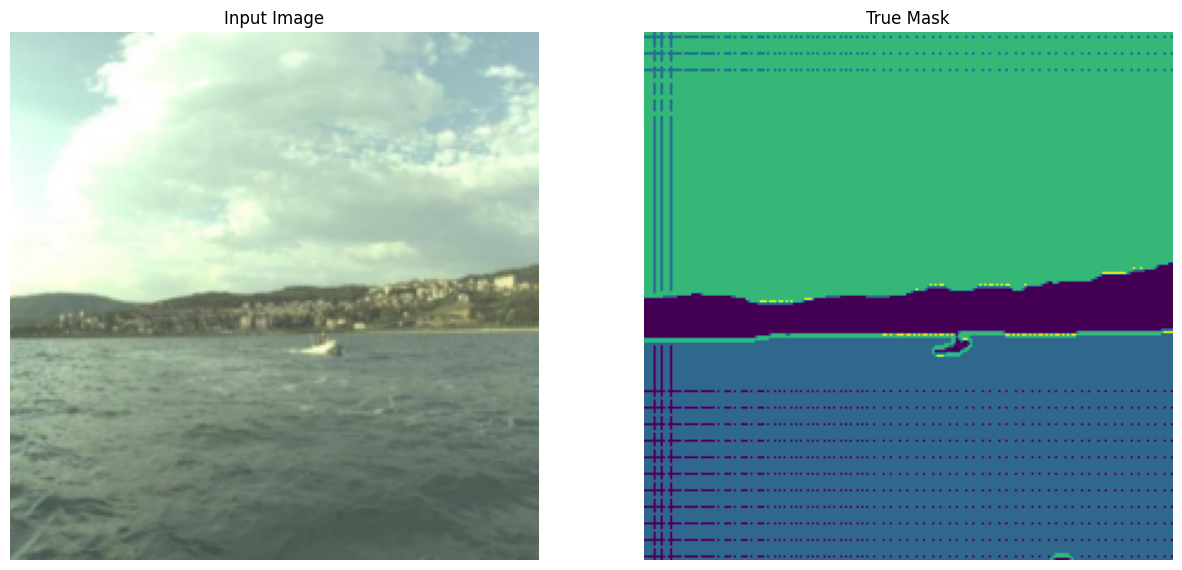

In [17]:
def show_predictions(model, dataset, num=1, show_sample=False, merge=False, batch_size=BATCH_SIZE):
    '''
    For a given dataset plots one image, its true mask, and predicted mask

    Args
    ----------
    model: PyTorch model
    dataset (optional): PyTorch DataLoader object, defaults first image in testing set
    num (optional): int
    show_sample (optional): bool: if True, display prediction for sample image

    Returns
    ----------
    Nothing, graph will be displayed
    '''
    model.eval()
    batches = num // batch_size + 1
    remainder = num % batch_size
    sample_image, sample_mask = None, None

    if show_sample and sample_image is not None and sample_mask is not None:
        sample_image = sample_image.unsqueeze(0)  # Add batch dimension
        sample_image = sample_image.to(device)
        with torch.no_grad():
            pred_mask = model(sample_image.to(device))
        display([sample_image.squeeze(0), sample_mask, create_mask(pred_mask)], merge=merge)
        return


    for i, (image, mask) in enumerate(dataset):
        if i == batches - 1:
            image = image[remainder].unsqueeze(0).to(device)  # Add batch dimension
            mask = mask[remainder].to(device)
            with torch.no_grad():
                pred_mask = model(image)
            display([image.squeeze(0), mask, create_mask(pred_mask)], merge=merge)
            return


# 示例代码
for images, masks in val_loader:
    sample_image, sample_mask = images[5], masks[5]/255
    break

display([sample_image, sample_mask])

### Training

In [18]:
UNLABELLED = 3.0

class CustomSparseCategoricalCrossentropy(nn.Module):
    def __init__(self):
        super(CustomSparseCategoricalCrossentropy, self).__init__()

    def forward(self, y_pred, y_true):
        # haslabel = (y_true != UNLABELLED).squeeze(-1)
        # haslabel = y_true != UNLABELLED
        # haslabel is torch.Size([32, 224, 224])
        # y_true = y_true[haslabel]
        # y_pred = y_pred[haslabel]
        # print(y_pred.shape, y_true.squeeze(1).shape, y_pred.dtype, y_true.long().dtype)
        return F.cross_entropy(y_pred, y_true.squeeze(1).long(), reduction='mean')


# Define the custom loss function and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = CustomSparseCategoricalCrossentropy()


In [19]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [ ]:
def train_model_without_val(model, dataloaders, criterion, optimizer, num_epochs=25, device='cpu'):
    print("Using device:", device)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        model.train()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            # print('Pred', outputs.shape)
            # print('True', labels.squeeze(1).long(), labels.squeeze(1).long().shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / (len(dataloaders.dataset) * 244*244)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

In [ ]:
model = train_model_without_val(model, train_loader, criterion, optimizer, num_epochs=80, device=device)

In [ ]:
# Save the model
torch.save(model.state_dict(), 'result/model.pt')

In [52]:
# Load the model
model.load_state_dict(torch.load('result/model.pt'))

<All keys matched successfully>

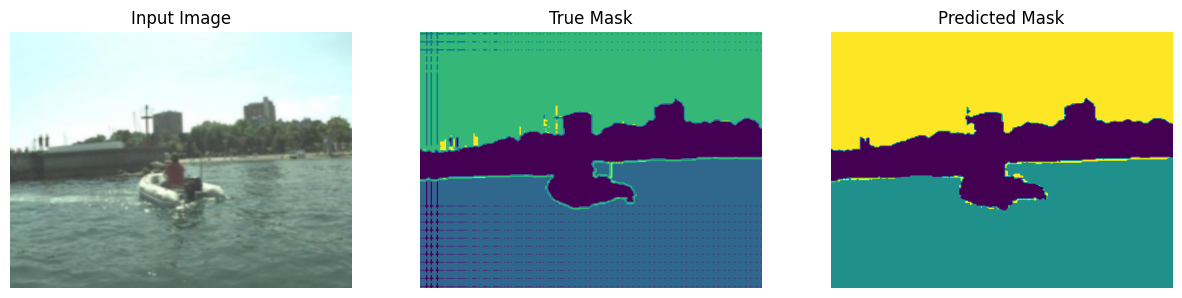

In [53]:
visual_transform = transforms.Compose([
    transforms.Resize((384, 512)),
])

# model.train()

image1, mask1 = val_dataset[1]
image1, mask1 = image1.unsqueeze(0).to(device), mask1.to(device).type(torch.uint8)
pre_mask1 = create_mask(model(image1)).type(torch.uint8)

image1 = visual_transform(image1)
mask1 = visual_transform(mask1)
pre_mask1 = visual_transform(pre_mask1)
display([image1.squeeze(0), mask1/255, pre_mask1/255])

### Adversarial Attack

In [22]:
def fgsm_attack(model, loss_fn, images, labels, epsilon):
    # model.eval()
    with torch.enable_grad():
        images.requires_grad = True

        outputs = model(images)

        loss = loss_fn(outputs, labels)

        model.zero_grad()
        loss.backward()

        data_grad = images.grad.data
        sign_data_grad = data_grad.sign()
        perturbed_image = images + epsilon * sign_data_grad

        perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

In [32]:
perturbed_image = fgsm_attack(model, criterion, image1, mask1, 0.01)

perturbed_pred_mask = create_mask(model(perturbed_image)).type(torch.uint8)
perturbed_pred_mask = visual_transform(perturbed_pred_mask)

display([image1.squeeze(0), mask1/255, pre_mask1/255, perturbed_pred_mask/255])

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 32 but got size 31 for tensor number 1 in the list.

### Test the model after adversarial training

tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]]],
       device='cuda:0') tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]]],
       device='cuda:0')


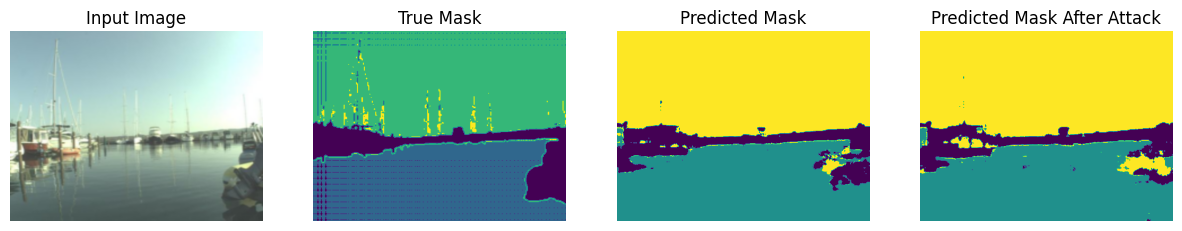

In [24]:
# Load the trained model
model_defense = unet_model(N_CLASSES)
model_defense.load_state_dict(torch.load('result/model_attacked.pt'))
model_defense.to(device)

# Predict the new attacked image
perturbed_pred_mask_defense = create_mask(model_defense(perturbed_image)).type(torch.uint8)
perturbed_pred_mask_defense = visual_transform(perturbed_pred_mask_defense)

print(mask1/255, perturbed_pred_mask_defense/255)

display([image1.squeeze(0), mask1/255, perturbed_pred_mask_defense/255, perturbed_pred_mask/255])

##### Below to be completed

In [ ]:
# def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device='cpu'):
#     # best_model_wts = copy.deepcopy(model.state_dict())
#     print("Using device: ", device)
#     best_loss = float('inf')

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)

#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()
#             else:
#                 model.eval()

#             running_loss = 0.0
#             running_corrects = 0

#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 optimizer.zero_grad()

#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     loss = criterion(outputs, labels)

#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 running_loss += loss.item() * inputs.size(0)
#                 _, preds = torch.max(outputs, 1)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

#             print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#             if phase == 'val' and epoch_loss < best_loss:
#                 best_loss = epoch_loss
#                 best_model_wts = copy.deepcopy(model.state_dict())

#             # Log the metrics to TensorBoard
#             # writer.add_scalar(f'{phase} Loss', epoch_loss, epoch)
#             # writer.add_scalar(f'{phase} Accuracy', epoch_acc, epoch)

#     model.load_state_dict(best_model_wts)
#     return model

In [ ]:
# dataloaders = {'train': train_loader, 'val': val_loader}
# model = train_model(model, dataloaders, criterion, optimizer, num_epochs=5, device=device)